In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import random

# from data.data_accessors import tmprss2_to_pandas
import numpy as np
from rdkit import Chem, DataStructs
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats

from sklearn.svm import LinearSVC
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score

import pickle

random.seed(2)

os.chdir('/Users/JacobUmans/tmprss2/notebooks')

In [2]:
# collect dataset
assays = pd.read_pickle('../processed_data/combined_dataset.pkl')
assays = assays[assays.activity_target.isin(['Active', 'Inactive'])]  # get rid of any 'Inconclusive'

dcm = pd.read_pickle('../processed_data/DarkChemicalMatter_processed.pkl.gz')

# testing data:
screening_data = pd.read_pickle('../processed_data/screening_data_processed.pkl')

In [3]:
screening_data

,source,name,morgan_fingerprint
0,drugbank,Bivalirudin,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,drugbank,Leuprolide,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,drugbank,Goserelin,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,drugbank,Gramicidin D,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,drugbank,Desmopressin,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
21019,broad,zotepine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
21020,broad,zoxazolamine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
21021,broad,zoxazolamine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
21022,broad,ZSTK-474,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [4]:
X_assays = np.stack(assays.morgan_fingerprint)
y_assays = np.ones(len(X_assays))

X_dcm = np.stack(dcm.morgan_fingerprint)
y_dcm = np.zeros(len(X_dcm))

X_combined = np.append(X_assays, X_dcm, axis = 0)
y_combined = np.append(y_assays, y_dcm)

X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2)

In [5]:
# Use SKLearn GridSearch CV function to identify optimal C parameter for SVM regression (training set)
Cs = np.logspace(-6, 2, 16)
clf = GridSearchCV(estimator=LinearSVC(random_state=0, tol=1e-5), param_grid=dict(C=Cs), n_jobs=-1)
clf.fit(X_train, y_train) 
c_param_SVC_train = clf.best_estimator_.C

In [6]:
c_param_SVC_train

2.5118864315095824

In [7]:
SVM_validation = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5, C=c_param_SVC_train))
SVM_validation.fit(X_train, y_train)

pred = SVM_validation.predict(X_test)
accuracy = np.sum(pred == y_test)/y_test.size
accuracy

0.999750418939637

In [8]:
i = 0
false_positive = 0
total_positive = 0
false_negative = 0
total_negative = 0
while(i < len(pred)):
    if(y_test[i] == 0):
        total_negative += 1
        if(pred[i] == 1):
            false_positive += 1
    elif(y_test[i] == 1):
        total_positive += 1
        if(pred[i] == 0):
            false_negative += 1 
    i = i + 1

false_positive/total_positive

0.016574585635359115

In [9]:
false_negative/total_negative

0.00014354410392593124

In [10]:
Cs = np.logspace(-6, 2, 16)
clf = GridSearchCV(estimator=LinearSVC(random_state=0, tol=1e-5), param_grid=dict(C=Cs), n_jobs=-1)
clf.fit(X_combined, y_combined) 
c_param_SVC_test = clf.best_estimator_.C

In [11]:
c_param_SVC_test


100.0

In [12]:
SVM_testing = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5, C=c_param_SVC_test))
SVM_testing.fit(X_combined, y_combined)

screening_compounds = np.stack(screening_data.morgan_fingerprint)

pred = SVM_testing.predict(screening_compounds)
screening_data['predictions'] = pred
inactiveCompounds = screening_data[(screening_data['predictions'] == 0)].index
active_screening_compounds = screening_data.drop(inactiveCompounds)

In [13]:
len(active_screening_compounds)

503

In [14]:
#split training and testing data for each dataset
y_assays_logKi = np.log10(assays.acvalue_scaled_to_tmprss2.fillna(assays.acvalue_target))

train_X, test_X, train_y, test_y = train_test_split(X_assays, y_assays_logKi, test_size=0.2)

In [15]:
# Use SKLearn GridSearch CV function to identify optimal C parameter for SVM regression (training set)
Cs = np.logspace(-6, 2, 16)
clf = GridSearchCV(estimator=LinearSVR(random_state=0, tol=1e-5), param_grid=dict(C=Cs), n_jobs=-1)
clf.fit(train_X, train_y) 
c_param_SVR_test = clf.best_estimator_.C


In [16]:
c_param_SVR_test

0.0630957344480193

SVR RMSE:1.042904345676188
(0.7528435526759596, 5.598687070179459e-34)


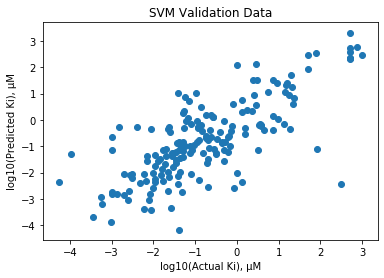

In [17]:
#Run SVM regression using SKLearn on test set. Linear regression for prediction accuracy
svmReg = make_pipeline(StandardScaler(), LinearSVR(random_state=0, tol=1e-5, C=c_param_SVR_test))
svmReg.fit(train_X, train_y)

pred = svmReg.predict(test_X)
MSE = mean_squared_error(test_y, pred)
RMSE = np.sqrt(MSE)
print("SVR RMSE:{}".format(RMSE))

plt.scatter(test_y, pred)
plt.xlabel('log10(Actual Ki), μM')
plt.ylabel('log10(Predicted Ki), μM')
plt.title('SVM Validation Data')

corr = scipy.stats.pearsonr(test_y, pred)
print(corr)

In [18]:
#SKLearn C parameter optimization
Cs = np.logspace(-6, 2, 16)
clf_full = GridSearchCV(estimator=LinearSVR(random_state=0, tol=1e-5), param_grid=dict(C=Cs), n_jobs=-1)
clf_full.fit(X_assays, y_assays_logKi) 
c_param_full = clf_full.best_estimator_.C

/Users/JacobUmans/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [19]:
c_param_full 

0.001584893192461114

In [20]:
#Run regressor (trained on full dataset)
test_compounds = np.stack(active_screening_compounds.morgan_fingerprint)

svmReg_full = make_pipeline(StandardScaler(), LinearSVR(random_state=0, tol=1e-5, C=c_param_full))
svmReg_full.fit(X_assays, y_assays_logKi)
pred_values = svmReg_full.predict(test_compounds)

In [21]:
active_screening_compounds['pred_value'] = pred_values
active_screening_compounds.sort_values(by='pred_value').head(20)

,source,name,morgan_fingerprint,predictions,pred_value
10743,drugbank,Lenacapavir,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,-3.027854
4517,drugbank,Ularitide,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1.0,-3.020273
10813,reframe,BMS-654457,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,-2.698966
3206,drugbank,CRA_11092,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,-2.623755
2928,drugbank,RWJ-51084,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,-2.203698
19603,broad,substance-p,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1.0,-2.188340
10241,drugbank,AMY-101,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,-2.123101
2513,drugbank,RWJ-56423,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,-2.016931
1841,drugbank,CRA_17312,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,-1.991248
1821,drugbank,CRA_16847,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,-1.945643


(array([ 3.,  1.,  3.,  8.,  8., 15., 54., 71., 61., 68., 70., 56., 41.,
        21., 12.,  5.,  2.,  1.,  2.,  1.]),
 array([-3.02785436, -2.69189523, -2.3559361 , -2.01997697, -1.68401784,
        -1.34805871, -1.01209958, -0.67614044, -0.34018131, -0.00422218,
         0.33173695,  0.66769608,  1.00365521,  1.33961435,  1.67557348,
         2.01153261,  2.34749174,  2.68345087,  3.01941   ,  3.35536913,
         3.69132827]),
 <a list of 20 Patch objects>)

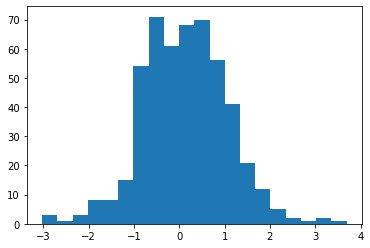

In [22]:
plt.hist(active_screening_compounds.pred_value, bins = 20)

In [23]:
i=active_screening_compounds[active_screening_compounds['name']=='Nafamostat']
i

,source,name,morgan_fingerprint,predictions,pred_value
8697,drugbank,Nafamostat,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,-0.538736
10797,reframe,Nafamostat,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1.0,-0.760559
